# Surface Corrections


In [1]:
from PeriFlakes import *
from SimDataDB import *
from matplotlib import pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

In [2]:
sdb = SimDataDB('surfaceresults.db')

In [81]:
H = 2.0 ; T = 1.0 ; E = 1.0 ; nu = 0.25;
solutions = {'uniaxial': (1, T*H*(2.0*nu**2+nu-1.0)/(E*(nu-1))),
             'isotropic':(1, T*H*(1.0-nu-2.0*nu**2)/E),
             'shear':    (0, 2.0*T*H*(1.0+nu)/E) }

In [82]:
L=1.0
N=20
delta= 1.5*2.0*L/float(N)
PB = PeriBlock(L,N,delta,ficticious=True,E=E,nu=nu)
PB.setbcs([(PB.right,0),(PB.left,0),(PB.bottom,1)], [(PB.ftop,[0,1])])

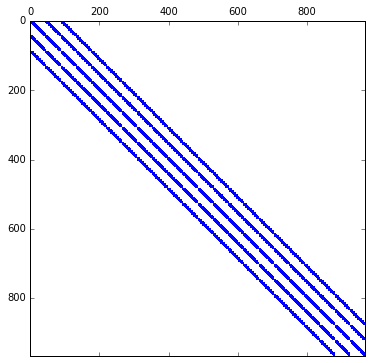

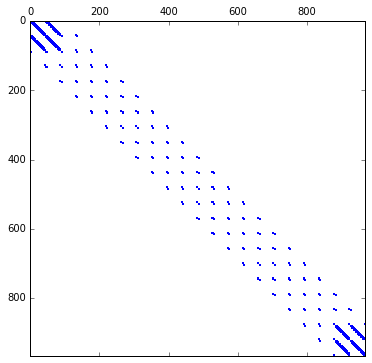

In [83]:
K,R = PB._assemble_KR("Fbased","cubic")
plt.spy(K,marker=',')
plt.show()
Kf,Rf = PB._assemble_KR_fict("standard","Fbased","cubic")
plt.spy(Kf,marker=',')
plt.show()


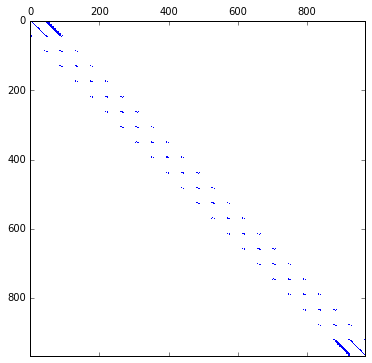

In [84]:
Kf,Rf = PB._assemble_KR_fict("bobaru","Fbased","cubic")
plt.spy(Kf,marker=',')
plt.show()

In [85]:
for e in PB.HFictStencil4:
    print
    for l in PB.dm_PtVec.Get_List(e):
        for m in PB.dm_PtVec.Get_List(e):
            print Kf[l,m]/4.5,
        print 


-2.11111111111 0.0 2.11111111111 0.0 0.0 -0.263888888889 0.0 0.263888888889
0.0 -2.11111111111 0.0 2.11111111111 -0.263888888889 0.0 0.263888888889 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 -0.263888888889 2.11111111111 0.0 -2.11111111111 0.0 0.0 0.0
-0.263888888889 0.0 0.0 2.11111111111 0.0 -2.11111111111 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

-2.11111111111 0.0 2.11111111111 0.0 0.0 -0.263888888889 0.0 0.263888888889
0.0 -2.11111111111 0.0 2.11111111111 -0.263888888889 0.0 0.263888888889 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

-2.11111111111 0.0 2.11111111111 0.0 0.0 -0.263888888889 0.0 0.263888888889
0.0 -2.11111111111 0.0 2.11111111111 -0.263888888889 0.0 0.263888888889 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [86]:
for e in PB.HFictStencil3:
    print
    print Rf[PB.dm_PtVec.Get_List(e)]
    for l in PB.dm_PtVec.Get_List(e):
        for m in PB.dm_PtVec.Get_List(e):
            print Kf[l,m]/4.5,
        
        print 


[ 0.  0.  0.  0.  0.  0.]
-2.11111111111 0.0 2.11111111111 0.527777777778 0.0 -0.527777777778
0.0 -2.11111111111 0.527777777778 2.11111111111 -0.527777777778 0.0
0.0 0.0 -2.11111111111 0.0 2.11111111111 0.0
0.0 0.0 0.0 -2.11111111111 0.0 2.11111111111
0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0

[ 0.  0.  0.  0.  0.  0.]
-2.11111111111 0.0 2.11111111111 0.527777777778 0.0 -0.527777777778
0.0 -2.11111111111 0.527777777778 2.11111111111 -0.527777777778 0.0
0.0 0.0 -2.11111111111 0.0 2.11111111111 0.0
0.0 0.0 0.0 -2.11111111111 0.0 2.11111111111
0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0

[ 0.   -1.25  0.    0.    0.    0.  ]
-2.11111111111 0.0 2.11111111111 0.527777777778 0.0 -0.527777777778
0.0 -2.11111111111 0.527777777778 2.11111111111 -0.527777777778 0.0
0.0 0.0 -2.11111111111 0.0 2.11111111111 0.0
0.0 0.0 0.0 -2.11111111111 0.0 2.11111111111
0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0

[ 0.   -1.25  0.    0.    0.    0.  ]
-2.11111111111 0.0 2.11111111111 0.52777777777

## Finite difference stencil

These types of surface correction effects are implemented in [ficticious_kernels_pop.py](PeriFlakes/ficticious_kernels_pop.py). 
The finite difference stencil can be generalized by defined a strain between two points,
\begin{equation}
\epsilon^{ab} = \frac{\left(\mathbf{u}^a-\mathbf{u}^b\right)\cdot
	                  \left(\mathbf{x}^a-\mathbf{x}^b\right) }{
					  \left(\mathbf{x}^a-\mathbf{x}^b\right)\cdot
	                  \left(\mathbf{x}^a-\mathbf{x}^b\right) },
\end{equation}
and a normal between two points,
\begin{equation}
\mathbf{n}^{ab} = \frac{\mathbf{x}^a-\mathbf{x}^b}{\left|\mathbf{x}^a-\mathbf{x}^b\right|},
\end{equation}
where $a$ and $b$ are index arguments.
Then, in the direction normal to the surface, $\mathbf{n}^n = \mathbf{n}^{fo}$ and $\epsilon^n=\epsilon^{fo}$.
In the tangential direction, the normal and strain are averaged by both directions to obtain a central finite difference,
$\mathbf{n}^t = \left( \mathbf{n}^{+o} + \mathbf{n}^{o-} \right) / 2$ and 
$\epsilon^t = \left( \epsilon^{+o} + \epsilon^{o-} \right) / 2$. 
If the ficticious node is all the way at an end, only one of the winded directions is used. The final constraint is
\begin{equation}
0 = \epsilon^{n}\mathbf{n}^n + \nu \epsilon^t \mathbf{n}^t -
\bar{\mathbf{t}} * \frac{1}{E} \left[\begin{array}{cc}
1+\nu & 1-\nu^{2}\\\\
1-\nu^{2} & 1+\nu
\end{array} \right] \mathbf{n}^n
\end{equation}
where $*$ is elementwise multiplication.

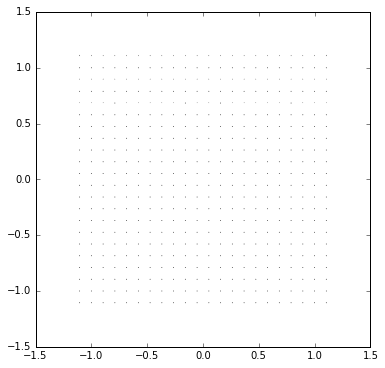

In [93]:
u = PB.solve("Fbased","cubic",stab=2,fictmet='bobaru')
N = int(PB.NPart**0.5)
u = u.reshape(N,N,2)
x = PB.x.reshape(N,N,2)
ax = plt.gca()
ax.quiver(x[:,:,0],x[:,:,1],u[:,:,0],u[:,:,1],angles='uv',scale_units='xy',scale=10.0)
ax.set_aspect('equal', 'datalim')

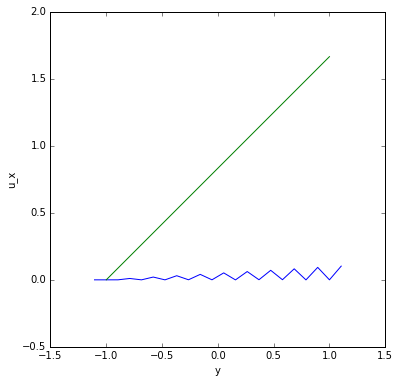

In [94]:
plt.plot(x[:,N/2,1],u[:,N/2,1])
plt.plot([-1,1],[0,solutions['uniaxial'][1]])
plt.xlabel('y'); plt.ylabel('u_x');

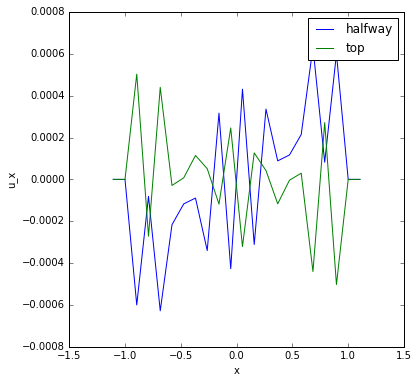

In [95]:
plt.plot(x[:,N/2,1],u[N/2,:,0],label='halfway');
plt.plot(x[:,N/2,1],u[-1,:,0],label='top');
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');